In [1]:
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, models, datasets
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import os
import numpy as np
import time
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import cv2

In [2]:
batch_size = 32
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
if torch.cuda.is_available() == True:
    device = torch.device('cuda:7')
    print(torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    
device

device(type='cpu')

In [4]:
def load_model(name):
    model = models.vgg16(pretrained = True)
    last_layer = nn.Linear(4096, 10)
    model.classifier[6] = last_layer
    
    model.load_state_dict(torch.load(f'./models/model_{name}.pth'))
    return model


# returns accuracy against ground truth and set of correctly classified images/labels
def test_model(model):
    model.eval()
    correct = 0
    total = 0
    correct_images = []
    correct_labels = []
    
    with torch.no_grad():
        batch_num = 0
        
        
        for inputs,labels in test_loader:
            batch_num += 1
                
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            equals = preds.eq(labels) #tensor[32 * bools]
            correct += equals.sum().item()
            total += labels.size(0)
            
            #get indices of correct classification
            indices = []
            i = 0
            for success in equals:
                if success:
                    indices.append(i)
                i+=1
            # add correct images/labels to list
            for ind in indices:
                correct_images.append(inputs[ind])
                correct_labels.append(labels[ind])

    acc = correct/total
    print('acc',acc)
    print('[correct: %d; len(correct_im): %d]' %(correct, len(correct_images)))
    
    return acc, correct_images, correct_labels

In [5]:
# load trained model and get correct testing data
name = 1
model1 = load_model(name)
test_acc, correct_images, correct_labels = test_model(model1)
print(test_acc, len(correct_images)) #baseline testing acc = 0.8536

acc 0.8536
[correct: 8536; len(correct_im): 8536]
0.8536 8536


In [6]:
import random 
sample_images, sample_labels = zip(*random.sample(list(zip(correct_images, correct_labels)), 1000))

In [7]:
import random 
from deap import algorithms, base, creator, tools 
import numpy as np

# minimize the fitness value 
creator.create("FitMin", base.Fitness, weights=(-1.0,))
creator.create("Ind", list, fitness=creator.FitMin)


In [8]:
#  CIFAR = 32x32
SIZE = 32
#population size 
POP_SIZE = 40
# one-pixel
NUM_PIXEL_ATTACK = 1

In [9]:
#img: tensor
def imshow(img, name):
    img = img.cpu().detach()
    img = np.asarray(img, dtype='int64')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.show()
    
def imshow(img):
    plt.imshow(transforms.ToPILImage()(img), interpolation="bicubic")
    plt.show()

In [10]:
# populate with x,y and RGB values 
def generate_ind(size):
    # uniformly-distributed (x,y)
    x = random.randint(0,size-1)
    y = random.randint(0,size-1)
    # Normal RGB value, clamped between [0,255]
    R = random.gauss(128, 127)
    R = max(0, min(R, 255))
    G = random.gauss(128, 127)
    G = max(0, min(G, 255))
    B = random.gauss(128,127)
    B = max(0, min(B, 255))
    
    return (x,y,R,G,B)


# return logit of targeted class prediction
# im: original image; tensor.Size(3,32,32)
# label: ground truth; scalar
def eval_adv(individual, im, label):
    
    #extract features
    ind = individual[0]
    x = ind[0]
    y = ind[1]
    r = ind[2]
    g = ind[3]
    b = ind[4]
    
    # apply change to original image
    adv_im = im.clone().detach() # to prevent contamination 
    adv_im[0][y][x] = r 
    adv_im[1][y][x] = g
    adv_im[2][y][x] = b
    
    # model prediction of ground truth class of this individual
    eval_im = torch.reshape(adv_im, (1,3,32,32)) #need [1,3,32,32] shape for model pred
    
    ##change name of model to model1
    model1.eval()
    with torch.no_grad():
        prob = model1(eval_im) #tensor([[10 probabilities]]), .Size([1,10])
    res = prob[0][label].item()
    
    return res,

In [11]:
toolbox = base.Toolbox()
toolbox.register("attribute", generate_ind, SIZE)
toolbox.register("ind", tools.initRepeat, creator.Ind, toolbox.attribute, n=NUM_PIXEL_ATTACK)
toolbox.register("pop", tools.initRepeat, list, toolbox.ind)

toolbox.register("eval", eval_adv)

In [12]:
def three_random_nums():
    r1 = random.randint(0,POP_SIZE-1)
    r2 = random.randint(0,POP_SIZE-1)
    r3 = random.randint(0,POP_SIZE-1)
    while r1 == r2 or r1 == r3 or r2 == r3: 
        r1 = random.randint(0,POP_SIZE-1)
        r2 = random.randint(0,POP_SIZE-1)
        r3 = random.randint(0,POP_SIZE-1)
    return r1,r2,r3

#evolve solution features given three random candidate solutions
def evolve(p1, p2, p3):
    new_x = p1[0] + 0.5*(p2[0] - p3[0])
    new_x = int(32 * ((new_x + 16)/64))
    
    new_y = p1[1] + 0.5*(p2[1] - p3[1])
    new_y = int(32 * ((new_y + 16)/64))
    
    new_r = p1[2] + 0.5*(p2[2] - p3[2])
    new_r = 256 * ((new_r + 128)/512)
    
    new_g = p1[3] + 0.5*(p2[3] - p3[3])
    new_g = 256 * ((new_g + 128)/512)
    
    new_b = p1[4] + 0.5*(p2[4] - p3[4])
    new_b = 256 * ((new_b + 128)/512)
    
    return (new_x, new_y, new_r, new_g, new_b)

In [13]:
# create a single one-pixel adversarial image 
def px_attack(im, label):
    since = time.time()
    
    im_pop = []
    label_pop = []
    for i in range(POP_SIZE):
        im_pop.append(im)
        label_pop.append(label)
    
    pop = toolbox.pop(n=POP_SIZE)
    fitnesses = list(map(toolbox.eval, pop, im_pop, label_pop))

    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    fits = [ind.fitness.values[0] for ind in pop]
    
    g = 0 # begin EA 
    while g<5:
    
        g += 1
        evolution_t = time.time()
        
        #generate children by differential evolution
        offspring = list(map(toolbox.clone, pop))
        for child in offspring:
            # pick three random candidate solutions
            r1,r2,r3 = three_random_nums()
            p1 = pop[r1][0]
            p2 = pop[r2][0]
            p3 = pop[r3][0]
            
            # evolve (x,y,r,g,b) attributes of child
            child[0] = evolve(p1,p2,p3)
            
        # get fitness values of children
        children_fitnesses = map(toolbox.eval, offspring, im_pop, label_pop)
        for child, fit in zip(offspring, children_fitnesses):
            child.fitness.values = fit
        child_fits = [child.fitness.values[0] for child in offspring]
        
        #replace parent if child has 'lower' fitness
        for parent, p_fit, c_fit in zip(pop, fits, child_fits):
            if c_fit < p_fit: 
                del parent.fitness.values
                parent.fitness.values = c_fit,    
        fits = [ind.fitness.values[0] for ind in pop]
        
        if min(fits) < 0:
            break    #breaks out if (likely) successful attack, i.e. ground truth pred < 0
    print('total time taken:', time.time() - since)
    
    #return the attributes of the pixel with lowest fitness value
    best = pop[np.argmin(np.asarray(fits))]
    return best[0]

In [14]:
# create adversarial images of every sampled correctly classified images
def get_best_px(model):
    atk_set = []
    for im, label in zip(sample_images, sample_labels):
        attr = px_attack(im, label)
        atk_set.append(attr)
    return atk_set

atk_set = get_best_px(model1)
print(len(atk_set)) # 1000

total time taken: 4.643763780593872
total time taken: 4.994067907333374
total time taken: 4.547881126403809
total time taken: 4.293844223022461
total time taken: 4.478643178939819
total time taken: 4.76291298866272
total time taken: 13.272392749786377
total time taken: 4.3763298988342285
total time taken: 13.165150880813599
total time taken: 4.214011192321777
total time taken: 4.434248924255371
total time taken: 4.780194997787476
total time taken: 4.30095911026001
total time taken: 4.2515549659729
total time taken: 4.534101963043213
total time taken: 4.9678778648376465
total time taken: 4.565320014953613
total time taken: 5.476686000823975
total time taken: 13.245190858840942
total time taken: 4.207228183746338
total time taken: 4.385809898376465
total time taken: 13.999058961868286
total time taken: 4.383692026138306
total time taken: 13.070767879486084
total time taken: 4.330451965332031
total time taken: 4.344856023788452
total time taken: 5.402707815170288
total time taken: 4.18779

total time taken: 3.999774932861328
total time taken: 12.032591104507446
total time taken: 4.009382963180542
total time taken: 4.012199878692627
total time taken: 12.179803133010864
total time taken: 4.027899980545044
total time taken: 3.9969208240509033
total time taken: 4.005218029022217
total time taken: 4.05756688117981
total time taken: 12.039347171783447
total time taken: 3.9950740337371826
total time taken: 12.043435096740723
total time taken: 4.012921094894409
total time taken: 12.180169105529785
total time taken: 4.035245895385742
total time taken: 4.0018980503082275
total time taken: 12.046489000320435
total time taken: 4.017346143722534
total time taken: 4.006547927856445
total time taken: 3.988986015319824
total time taken: 4.026370048522949
total time taken: 12.063354015350342
total time taken: 4.036839008331299
total time taken: 12.17131495475769
total time taken: 4.011290073394775
total time taken: 3.99259614944458
total time taken: 12.080705881118774
total time taken: 1

total time taken: 3.9542789459228516
total time taken: 11.738508224487305
total time taken: 3.906097173690796
total time taken: 11.794926881790161
total time taken: 3.9031829833984375
total time taken: 3.9039649963378906
total time taken: 3.945085048675537
total time taken: 3.8961517810821533
total time taken: 3.933704137802124
total time taken: 3.92537784576416
total time taken: 3.8985700607299805
total time taken: 3.9818429946899414
total time taken: 3.928565740585327
total time taken: 12.418442964553833
total time taken: 3.9640860557556152
total time taken: 3.8969528675079346
total time taken: 3.91459584236145
total time taken: 3.9323909282684326
total time taken: 3.8910930156707764
total time taken: 3.9402308464050293
total time taken: 3.8881938457489014
total time taken: 3.916078805923462
total time taken: 11.782015085220337
total time taken: 3.9037952423095703
total time taken: 3.8992130756378174
total time taken: 3.935293197631836
total time taken: 3.9061408042907715
total time 

total time taken: 3.898944616317749
total time taken: 3.945358991622925
total time taken: 3.92250919342041
total time taken: 3.920292854309082
total time taken: 11.724577188491821
total time taken: 3.952347993850708
total time taken: 3.8968019485473633
total time taken: 3.9445080757141113
total time taken: 3.896683931350708
total time taken: 3.9454751014709473
total time taken: 3.930398941040039
total time taken: 3.8899309635162354
total time taken: 3.940016269683838
total time taken: 3.888558864593506
total time taken: 3.9237892627716064
total time taken: 3.9177699089050293
total time taken: 3.9006221294403076
total time taken: 3.944423198699951
total time taken: 3.908426284790039
total time taken: 11.766897201538086
total time taken: 11.779113054275513
total time taken: 3.926919937133789
total time taken: 3.9069948196411133
total time taken: 3.9116017818450928
total time taken: 11.763966798782349
total time taken: 3.920945882797241
total time taken: 11.7359139919281
total time taken:

total time taken: 3.893752098083496
total time taken: 3.9351208209991455
total time taken: 3.8895580768585205
total time taken: 3.955986261367798
total time taken: 3.927993059158325
total time taken: 3.9031970500946045
total time taken: 11.772862911224365
total time taken: 3.914457082748413
total time taken: 12.306092023849487
total time taken: 3.922921895980835
total time taken: 4.016294002532959
total time taken: 3.9601402282714844
total time taken: 3.9227819442749023
total time taken: 3.9042718410491943
total time taken: 11.779653310775757
total time taken: 3.9085280895233154
total time taken: 11.819567203521729
total time taken: 11.766289949417114
total time taken: 11.717586994171143
total time taken: 3.9238288402557373
total time taken: 3.9054269790649414
total time taken: 3.9203150272369385
total time taken: 3.9639081954956055
total time taken: 11.728583812713623
total time taken: 3.8899729251861572
total time taken: 3.947206735610962
total time taken: 3.9122347831726074
total ti

In [87]:
###### 


#------#



#######

In [31]:
#im: tensor(3,32,32) , attr = tuple(xyrgb) -> return image with one-px atk 
def create_adv(im, attr):
    #extract attributes
    x = attr[0]
    y = attr[1]
    r = attr[2]
    g = attr[3]
    b = attr[4]
    # apply change to original image
    adv_im = im.clone().detach() # to prevent contamination 
    adv_im[0][y][x] = r 
    adv_im[1][y][x] = g
    adv_im[2][y][x] = b
    
    return adv_im

# get misclassification accuracy of attack
def atk_acc(model, atk_set):
    print('begin testing on one-pixel images')
    
    success = 0
    og_adv = [] # list of tuples(original_im, adv_im)
    true_misclass = [] #list of tuples(ground truth, misclassified as)
    successful_px = [] # list of tuples(xyrgb) that succeeded in attack
    
    model.eval()
    for attr, original_im, true_label in zip(atk_set, sample_images, sample_labels):
        
        adv_image = create_adv(original_im, attr)
        # model prediction of ground truth class of this individual
        eval_im = torch.reshape(adv_image, (1,3,32,32)) #need [1,3,32,32] shape for model pred
        with torch.no_grad():
            prob = model(eval_im)
        pred = prob[0].argmax().item()
        if pred != true_label:
            success += 1
            og_adv.append((original_im, adv_image))
            true_misclass.append((true_label, pred))
            successful_px.append(attr)
    print('returning successful attacks')

    return og_adv, true_misclass, successful_px,success/len(sample_images)
        

In [32]:
og_adv, true_misclass, attr, success_acc = atk_acc(model1, atk_set)
print(len(og_adv), len(true_misclass)) # should be same ; less than 1000
print(success_acc)

begin testing on one-pixel images
returning successful attacks
851 851
0.851


original cat


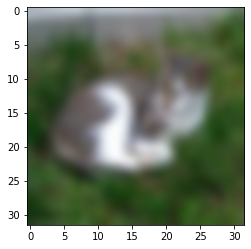

one-pixel attack bird
(19, 6, 245.7704238026274, 184.19985915226738, 14.62672774615514)


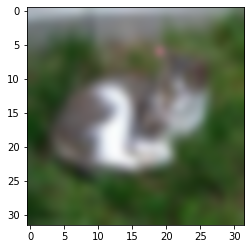

----
original car


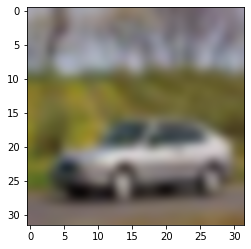

one-pixel attack plane
(11, 15, 255, 255, 141.23866475619982)


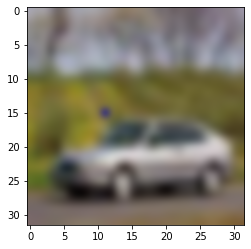

----
original horse


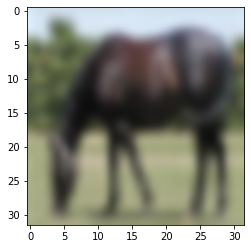

one-pixel attack bird
(5, 18, 0, 7.490375687166136, 68.20626366837122)


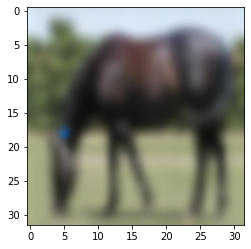

----
original horse


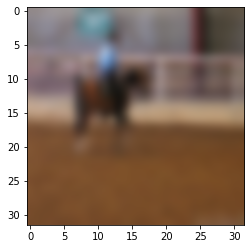

one-pixel attack plane
(15, 23, 255, 255, 207.5119579630817)


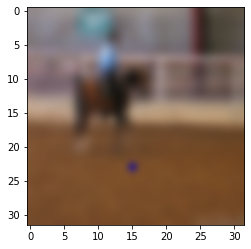

----
original truck


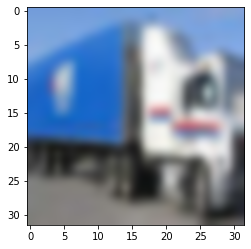

one-pixel attack bird
(13, 2, 255, 171.76939769885664, 194.75078641501784)


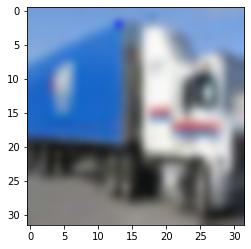

----
original truck


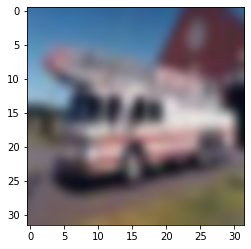

one-pixel attack bird
(18, 14, 255, 232.54158730167683, 116.88887164052544)


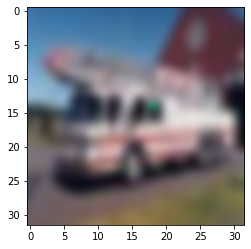

----
original cat


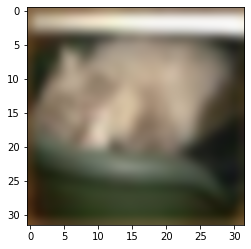

one-pixel attack plane
(28, 22, 186.76839353159903, 255, 213.11605478329184)


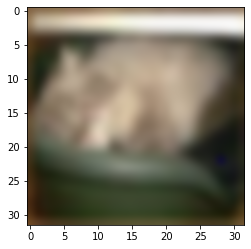

----
original truck


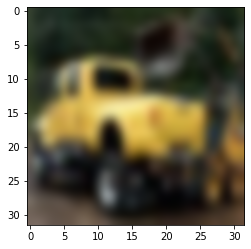

one-pixel attack plane
(0, 9, 52.007254603554856, 255, 205.69717649549793)


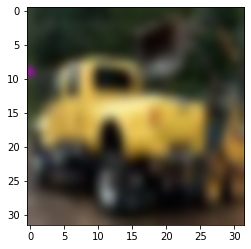

----


In [89]:
num_success = 8

# display four random images to compare pre/post attack
for i in range(num_success):
    ind = random.randint(0,len(og_adv))
    og_im = og_adv[ind][0]
    og_label = true_misclass[ind][0]
    adv_im = og_adv[ind][1]
    misclass = true_misclass[ind][1]
    xyrgb = attr[ind]
    
    print('original', classes[og_label])
    imshow(og_im)
    print('one-pixel attack', classes[misclass])
    print(xyrgb)
    imshow(adv_im)
    
    print('----')
    


low diff 0.028026342391967773


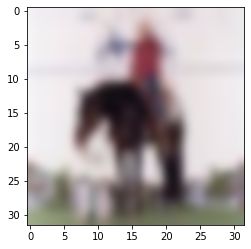

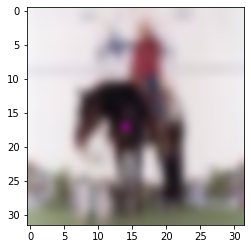

low diff 0.16405853629112244


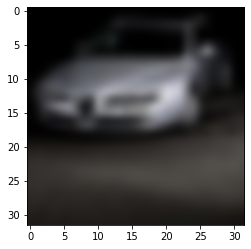

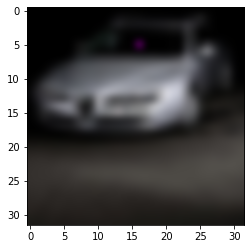

low diff 0.37413984537124634


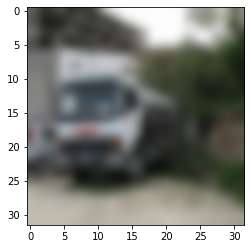

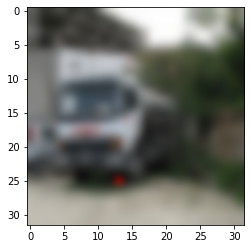

low diff 0.9070887565612793


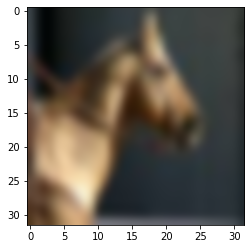

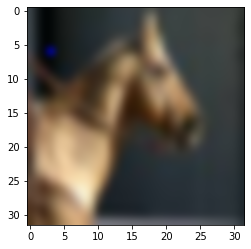

low diff 1.3190864324569702


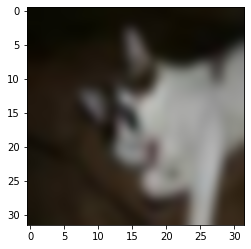

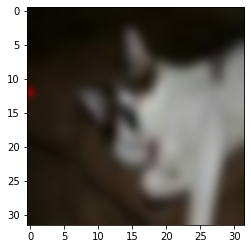

IndexError: list index out of range

In [86]:
# find Euclidean distance between original and successful adversary 

# og = og_adv[1][0]
# adv_im = og_adv[1][1]

# # imshow(og)
# # imshow(adv_im)

# dist = torch.norm(og*adv_im, 1, -1)
# print(dist)

# dist_og = torch.norm(og*og, 1, -1)
# print(dist_og)

# diff_map = ~dist.eq(dist_og)
# print(diff_map)
# # print(dist_og.eq(dist_og))

# print(diff_map.sum().item())

# print('??', dist - dist_og)
# print((dist-dist_og).sum().item())


print('===========\n')


# distance between original and successful adv_im
def get_distance():
    differences = [] # tuple(og_im, adv_im, diff_size) 
    for images in og_adv:
        og_im = images[0]
        adv_im = images[1]
        dist_diff = torch.norm(og_im * adv_im, 2, -1)
        dist_og = torch.norm(og_im * og_im, 2, -1)
        diff_size = (dist_diff - dist_og).sum().item()
        differences.append((images, diff_size))
    return differences
    
differences = get_distance()
differences.sort(key=lambda tup: tup[1])


#low differnce between orignal and adv 
for i in range(5):
    print('low diff',differences[i][1])
    og_im = differences[i][0][0]
    adv_im = differences[i][0][1]
    imshow(og_im)
    imshow(adv_im)

length = len(differences)
for i in range(5):
    print('high diff',differences[length-i][1])
    og_im = differences[length-i][0][0]
    adv_im = differences[length-i][0][1]
    imshow(og_im)
    imshow(adv_im)


# # print(differences)
# og_im = differences[0][0][0]
# adv_im = differences[0][0][1]
# imshow(og_im)
# imshow(adv_im)
# print(differences[0][1])


# og_im = differences[len(differences)- 1][0][0]
# adv_im = differences[len(differences)- 1][0][1]
# imshow(og_im)
# imshow(adv_im)
# print(differences[len(differences) - 1][1])

# var2 = torch.norm(((a * b)), 1, -1)
# print("Torch NORM L1 Distance is : ", var2)

In [67]:
print(len(large_diff))

6


In [43]:
#run model training/testing/attack

In [ ]:
num_epochs = 3
global best_acc
def train_model(model, criteria, optimizer, device, name):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    since = time.time()
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs ))
        print('-' * 10)
        
        model.train()
        running_loss = 0.0
        running_corrects = 0
        running_total = 0
        epoch_correct = 0
        epoch_total = 0
        batch_num = 0
        
        for inputs,labels in train_loader:
            batch_num += 1
            inputs = inputs.to(device)
            labels = labels.to(device)

            #zero the parameter gradient
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criteria(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_corrects += preds.eq(labels).sum().item()
            running_total += labels.size(0)
            
            epoch_correct += preds.eq(labels).sum().item()
            epoch_total += labels.size(0)


            #print mini-batch statistics every 400 mini-batches
            if batch_num % 400 == 0:
                print('[%d, %5d] av. batch loss: %.3f\tcorrect: %d' %
                      (epoch, batch_num, running_loss/400 , running_corrects))
                running_loss = 0.0
                running_corrects = 0
                running_total = 0
                
        epoch_acc = epoch_correct/epoch_total
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))    
    print('Best Acc: {:4f}'.format(best_acc))
       
    #load best model weights
    model.load_state_dict(best_model_wts)

    #save model
    if not os.path.isdir('models'):
            os.mkdir('models') 
    PATH = f'./models/model_{name}.pth'
    print('saving with path:', PATH)        
    torch.save(best_model_wts, PATH)
    
    return model, best_acc

